# Chi Analysis


---
**License**

Chi Analysis

 Fri Feb 21 11:30:00 2025\
 Copyright  2025\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 Chi_Analysis \
 Copyright (C) 2024 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Packages & Configs

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/Scripts")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

#Useful packages
import numpy as np
import math
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# GCRCatalogs
sys.path.insert(0, "/global/homes/c/cinlima/gcrcatalogs-new/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")

#Calibration functions
from bdata import DataB
from model_fitting import ModelFitting

## Data

### Clevar

In [2]:
# CLEVAR

# min_richness = 5
# min_halo_mass = 1e13 #Msun

# Halos/Clusters
# #CosmoDC2 + RedMaPPer: 'cosmoDC2_v1.1.4_redmapper_v0.8.1'
# RM_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True, tags={'mass':'richness'})

# #CosmoDC2: 'cosmoDC2_v1.1.4_image'
# halo_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True, tags={'mass':'mass_fof'})

# #Members
# RM_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)
# halo_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

# #Match catalogs
# mt = MembershipMatch()

# mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/cosmoDC2_RM_match_cross_membership')


### Data matched by ID

In [4]:
# test_matchdata = Table.read('CatalogsMatching/match_ID.fits')

# rich_data = test_matchdata["richness"]
# z_data = test_matchdata["redshift"]
# mass_data = test_matchdata["halo_mass"]
# r_err_data = test_matchdata["richness_err"]

# test_dt = Table([mass_data, rich_data, z_data, r_err_data], names=('mass', 'richness', 'redshift', 'richness_err'))


### NumCosmo's Matching By Proximity

In [3]:
mdata = Table.read('CatalogsMatching/match_proximity.fits')

rich_data = mdata["R"]
z_data = mdata["z"]
mass_data = mdata["mass"]

test_dt = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))


### Data threshold

In [5]:
test_dt = test_dt[test_dt['mass'] > 1e13]
test_dt = test_dt[np.logical_and(test_dt['redshift'] > 0, test_dt['redshift']< 3)]
test_dt = test_dt[np.logical_and(test_dt['richness'] > 0, test_dt['richness'] < 1e10)]

mass_dt = test_dt['mass']
red_dt = test_dt['redshift']
rich_dt = test_dt['richness']

print('Data')
print('\t\tMax \t\t\tMin')
print(f'Mass:\t\t{max(mass_dt):.2e}, \t\t{min(mass_dt):.2e}')
print(f'Redshift:\t{max(red_dt)}, \t{min(red_dt)}')
print(f'Richness:\t{max(rich_dt)}, \t{min(rich_dt)}')



Data
		Max 			Min
Mass:		1.90e+15, 		1.00e+13
Redshift:	1.1764284278635397, 	0.09084865138884513
Richness:	266.2950439453125, 	5.007844924926758


### Binning

In [6]:
# #Length of bins
# zl = 0.05
# ml = 0.05
# bd = DataB(test_dt, zl, ml)
# binned_mean = bd.get_bins_mean()
# binned_std = bd.get_bins_std()

# lnM_binned_mean = np.log(binned_mean['mass'])
# z_binned_mean = binned_mean['redshift']
# lnR_binned_mean = np.log(binned_mean['richness'])

# print(f'Total bins in binned_mean: {len(bd.get_bins_mean())}')


## Models fitting

In [7]:
fm = ModelFitting(test_dt) #Fit object

### Ascaso Fit Params

In [8]:
ascaso, fit_ascaso = fm.run_fit('ascaso')

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1.6094379124341     [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

In [9]:
lnR_mean_ascaso = fm.get_mean_model(ascaso, np.log(test_dt['mass']),  test_dt['redshift'])
lnR_std_ascaso = fm.get_std_model(ascaso, np.log(test_dt['mass']), test_dt['redshift'])

### Ext (ln(1+z)) Fit Params

In [10]:
ext_ln1pz, fit_ext = fm.run_fit('ext_ln1pz')

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

In [11]:
lnR_mean_ext_ln1pz = fm.get_mean_model(ext_ln1pz,  np.log(test_dt['mass']), test_dt['redshift'])
lnR_std_ext_ln1pz = fm.get_std_model(ext_ln1pz,  np.log(test_dt['mass']), test_dt['redshift'])

## Analysis

In [12]:
residuals_ext = (np.log(rich_dt) - lnR_mean_ext_ln1pz) / lnR_std_ext_ln1pz
residuals_asc = (np.log(rich_dt) - lnR_mean_ascaso) / lnR_std_ascaso

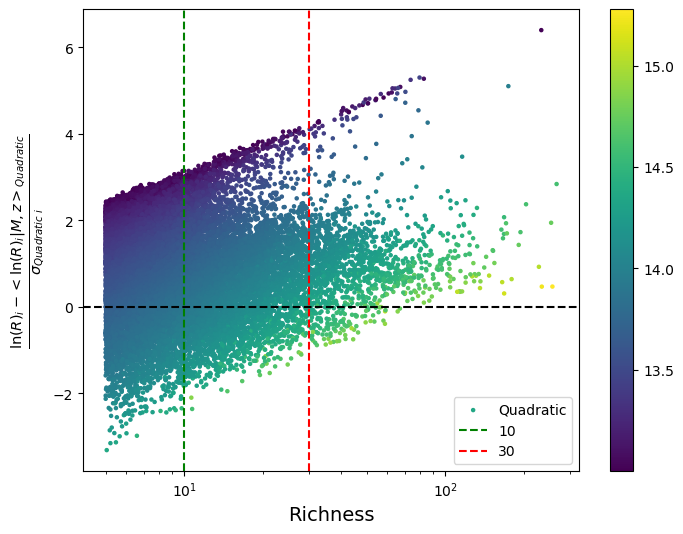

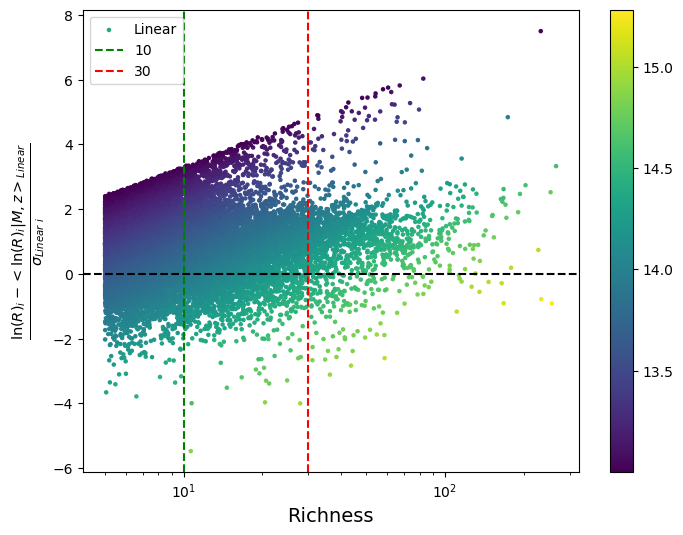

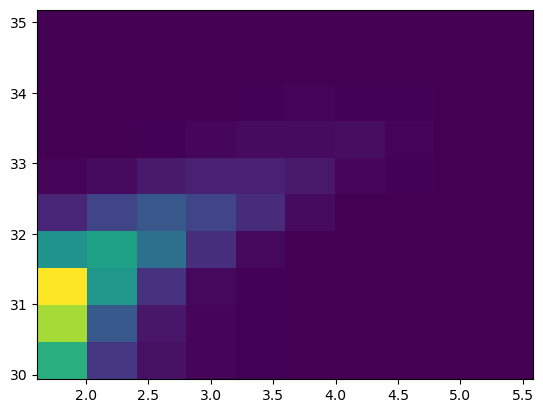

In [13]:
plt.figure(figsize=(8,6))

p2 = plt.scatter(rich_dt, residuals_ext, c= np.log10(mass_dt), s=5.0, label = 'Quadratic')

plt.colorbar(p2)

plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Quadratic} }{\sigma_{Quadratic \ i}}$', fontsize=15)
plt.axvline(x=10, color='g', ls='--', label='10')
plt.axvline(x=30, color='r', ls='--', label='30')
plt.axhline(y=0.0, color='k', ls='--')


plt.xscale('log')
plt.legend()
plt.xlabel('Richness', fontsize=14)

plt.show()

plt.figure(figsize=(8,6))

p1 = plt.scatter(rich_dt, residuals_asc, c= np.log10(mass_dt), s=5.0, label = 'Linear')

plt.colorbar(p1)

plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
plt.axvline(x=10, color='g', ls='--', label='10')
plt.axvline(x=30, color='r', ls='--', label='30')
plt.axhline(y=0.0, color='k', ls='--')


plt.xscale('log')
plt.legend()
plt.xlabel('Richness', fontsize=14)

plt.show()

plt.hist2d(np.log(rich_dt), np.log(mass_dt))
plt.show()


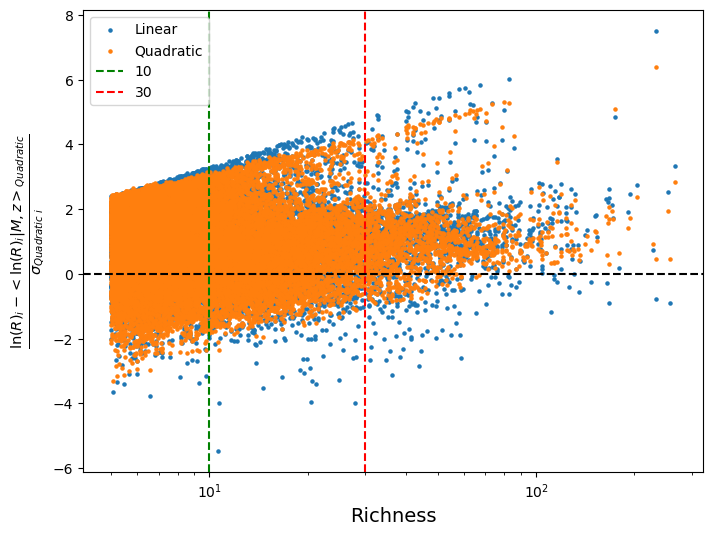

In [14]:
plt.figure(figsize=(8,6))

plt.scatter(rich_dt, residuals_asc, s=5.0, label = 'Linear')
plt.scatter(rich_dt, residuals_ext, s=5.0, label = 'Quadratic')

plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Quadratic} }{\sigma_{Quadratic \ i}}$', fontsize=15)
plt.axvline(x=10, color='g', ls='--', label='10')
plt.axvline(x=30, color='r', ls='--', label='30')
plt.axhline(y=0.0, color='k', ls='--')


plt.xscale('log')
plt.legend()
plt.xlabel('Richness', fontsize=14)

plt.show()

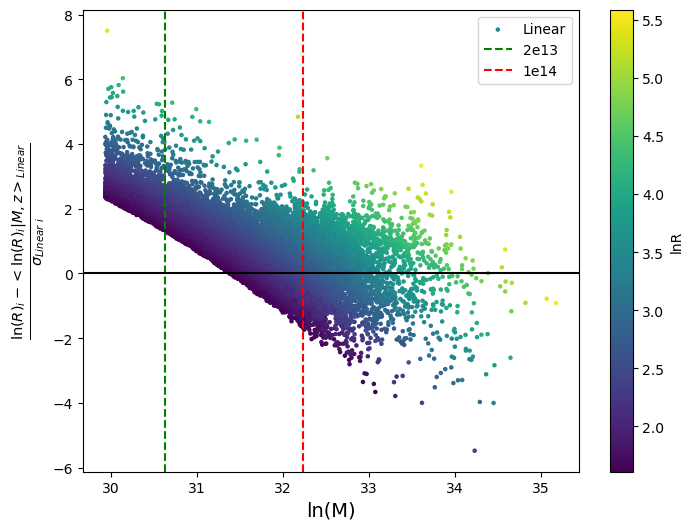

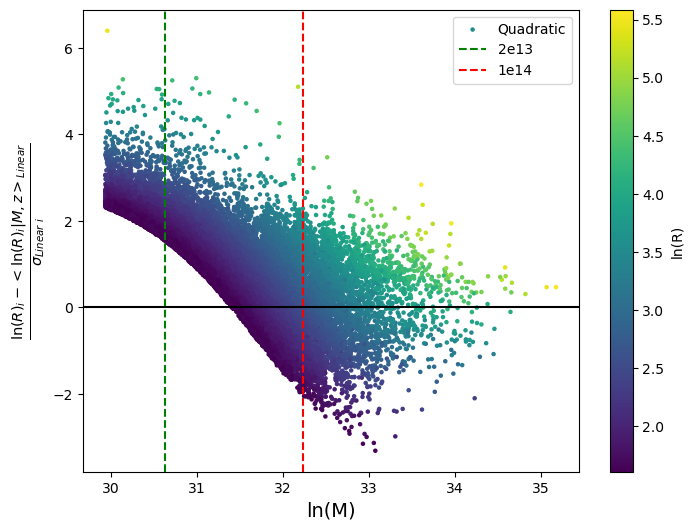

In [15]:
plt.figure(figsize=(8,6))

p3 = plt.scatter(np.log(mass_dt), residuals_asc, c = np.log(rich_dt),  s=5.0, label = 'Linear')
plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
plt.axvline(x=np.log(2e13), color='g', ls='--', label='2e13')
plt.axvline(x=np.log(1e14), color='r', ls='--', label='1e14')
plt.axhline(y=0.0, color='k', ls='-')

plt.colorbar(p3, label = 'lnR')

plt.legend()
plt.xlabel('ln(M)', fontsize=14)


plt.show()

plt.figure(figsize=(8,6))
p4=plt.scatter(np.log(mass_dt), residuals_ext, c = np.log(rich_dt),  s=5.0, label = 'Quadratic')
plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
plt.axvline(x=np.log(2e13), color='g', ls='--', label='2e13')
plt.axvline(x=np.log(1e14), color='r', ls='--', label='1e14')
plt.axhline(y=0.0, color='k', ls='-')

plt.colorbar(p4, label='ln(R)')

plt.legend()
plt.xlabel('ln(M)', fontsize=14)


plt.show()

In [16]:
# plt.scatter(np.log(mass_dt), residuals_ext, s=3.0)
# plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
# # plt.yscale('log')
# plt.xlabel('ln(M)', fontsize=14)
# plt.show()



In [17]:
# plt.scatter(np.log(mass_dt), residuals_ext - residuals_asc, s=3.0)
# plt.ylabel(r'$\chi_{Quad} - \chi_{Linear}$', fontsize=15)
# plt.xlabel('ln(M)', fontsize=14)
# # plt.yscale('log')
# plt.show()

In [18]:
# print(np.sum(residuals_ext ** 2 / len(residuals_ext)))
# print(np.sqrt(2*len(residuals_ext)) / len(residuals_ext))

# print(2 * np.sum(np.log(lnR_std_ext_ln1pz*2)) + np.sum(residuals_ext ** 2 ))
# print(np.sum(residuals_ext ** 2 ))
# print(2 * np.sum(np.log(np.sqrt(2*np.pi) * lnR_std_ext_ln1pz)))

# print(len(residuals_ext), len(residuals_asc) )

In [19]:
# print(np.sum(residuals_asc ** 2 / len(residuals_asc)))
# print(np.sqrt(2*len(residuals_asc)) / len(residuals_asc))

# print(2 * np.sum(np.log(2 * lnR_std_ascaso)) + np.sum(residuals_asc ** 2 ))
# print(np.sum(residuals_asc ** 2 ))
# print(2 * np.sum(np.log(np.sqrt(2*np.pi) * lnR_std_ascaso)))

In [20]:
# np.sum(lnR_std_ascaso/lnR_std_ext_ln1pz/len(lnR_std_ext_ln1pz))

In [21]:
# lk = fit_ascaso.peek_likelihood()
# mset = fit_ascaso.peek_mset()
# dset = lk.peek_dataset()
# data = dset.peek_data(0)

# print(np.sum(test_dt['redshift']-data.props.z_cluster.dup_array()))
# print(np.sum(np.log(test_dt['mass'])-data.props.lnM_cluster.dup_array()))
# print(np.sum(np.log(test_dt['mass'])-data.props.lnM_cluster.dup_array()))
# print(np.sum(np.log(test_dt['richness'])-data.props.lnR_cluster.dup_array()))

# lk.m2lnL_val(mset)
# mset["NcClusterMass"].props.M0